# CS470/CS670 Team 6 Final Project: Proposal for Pneumonia Detection Using Chest X-Ray Images

In [ ]:
# Import required libraries
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from tensorflow.keras.applications import MobileNetV2,ResNet50

# Suppress warnings
warnings.filterwarnings("ignore")


# 1. Load Dataset

In [ ]:
# Download dataset using kagglehub
import kagglehub
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print(f"Dataset downloaded to: {dataset_path}")

# Print directory structure
for root, dirs, files in os.walk(dataset_path):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files}")
    print("-" * 40)


100%|██████████| 2.29G/2.29G [00:56<00:00, 43.8MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Subdirectories: ['chest_xray']
Files: []
----------------------------------------
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
Subdirectories: ['chest_xray', '__MACOSX', 'train', 'val', 'test']
Files: []
----------------------------------------
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray
Subdirectories: ['train', 'val', 'test']
Files: ['.DS_Store']
----------------------------------------
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/train
Subdirectories: ['PNEUMONIA', 'NORMAL']
Files: ['.DS_Store']
----------------------------------------
Directory: /root/.cache/kagglehub/datasets/paultimothymoo

#  2. Partition Images of Training and Test Data to Seperate Pandas Dataframes

In [ ]:
# Prepare training data
def prepare_dataset(data_dir):
    filepaths, labels = [], []
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        for img_file in os.listdir(category_path):
            filepaths.append(os.path.join(category_path, img_file))
            labels.append(category)
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

train_dir = os.path.join(dataset_path, "chest_xray/train")
test_dir = os.path.join(dataset_path, "chest_xray/test")

df_train = prepare_dataset(train_dir)
df_test = prepare_dataset(test_dir)


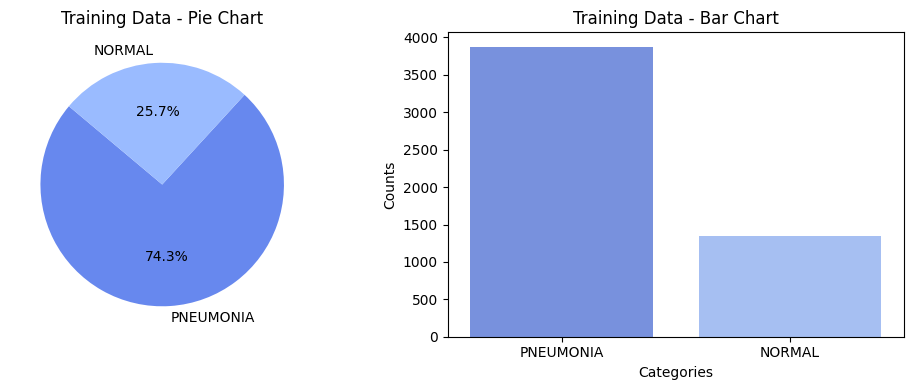

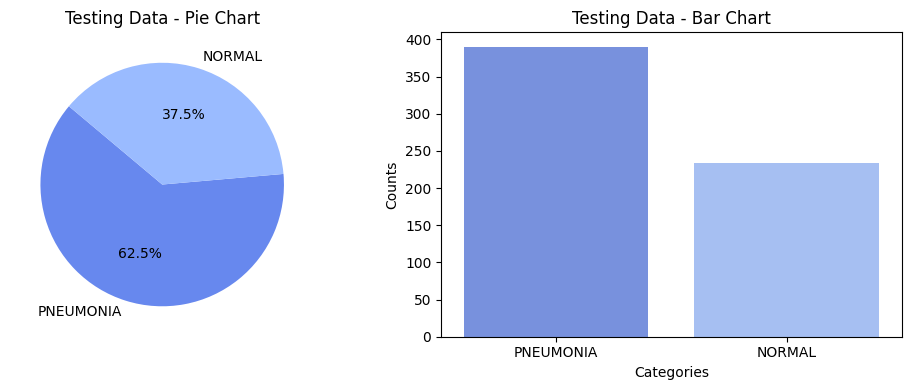

In [ ]:
# Visualize label distribution
def plot_label_distribution(df, title):
    label_counts = df['label'].value_counts()
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), facecolor='white')
    palette = sns.color_palette("coolwarm")

    # Pie chart
    axs[0].pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=palette)
    axs[0].set_title(f'{title} - Pie Chart')

    # Bar chart
    sns.barplot(x=label_counts.index, y=label_counts.values, ax=axs[1], palette=palette)
    axs[1].set_title(f'{title} - Bar Chart')
    axs[1].set_xlabel('Categories')
    axs[1].set_ylabel('Counts')

    plt.tight_layout()
    plt.show()

plot_label_distribution(df_train, "Training Data")
plot_label_distribution(df_test, "Testing Data")


# 3. Preprocessing

In [ ]:
#Preprocessing V2 - With Data augmentation techniques

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions and batch size
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

# Create data augmentation object
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values
    rotation_range=20,    # Rotate images randomly within 20 degrees
    width_shift_range=0.1,  # Shift horizontally by 10%
    height_shift_range=0.1,  # Shift vertically by 10%
    shear_range=0.1,       # Apply shearing
    zoom_range=0.2,        # Random zoom
    horizontal_flip=True,  # Flip horizontally
    validation_split=0.1   # Reserve 10% of training data for validation
)

# Load augmented training data
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Use binary mode for binary classification
    subset='training',    # Training subset
    seed=123              # Ensure reproducibility
)

# Load validation data (no augmentation, just rescaling)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.1)
val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=123
)

# Test dataset (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Do not shuffle for consistent evaluation
)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
"""
# Image dimensions and batch size
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

# Create datasets
train_dataset = image_dataset_from_directory(
    train_dir, validation_split=0.1, subset="training", seed=123,
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)
val_dataset = image_dataset_from_directory(
    train_dir, validation_split=0.1, subset="validation", seed=123,
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)
test_dataset = image_dataset_from_directory(
    test_dir, seed=123, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)

# Normalize pixel values
def normalize_dataset(ds):
    return ds.map(lambda x, y: (x / 255.0, y))

train_dataset = normalize_dataset(train_dataset)
val_dataset = normalize_dataset(val_dataset)
test_dataset = normalize_dataset(test_dataset)
"""

'\n# Image dimensions and batch size\nIMAGE_SIZE = (256, 256)\nBATCH_SIZE = 32\n\n# Create datasets\ntrain_dataset = image_dataset_from_directory(\n    train_dir, validation_split=0.1, subset="training", seed=123,\n    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE\n)\nval_dataset = image_dataset_from_directory(\n    train_dir, validation_split=0.1, subset="validation", seed=123,\n    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE\n)\ntest_dataset = image_dataset_from_directory(\n    test_dir, seed=123, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE\n)\n\n# Normalize pixel values\ndef normalize_dataset(ds):\n    return ds.map(lambda x, y: (x / 255.0, y))\n\ntrain_dataset = normalize_dataset(train_dataset)\nval_dataset = normalize_dataset(val_dataset)\ntest_dataset = normalize_dataset(test_dataset)\n'

# 4. Vizualization of Examples from Training Directory

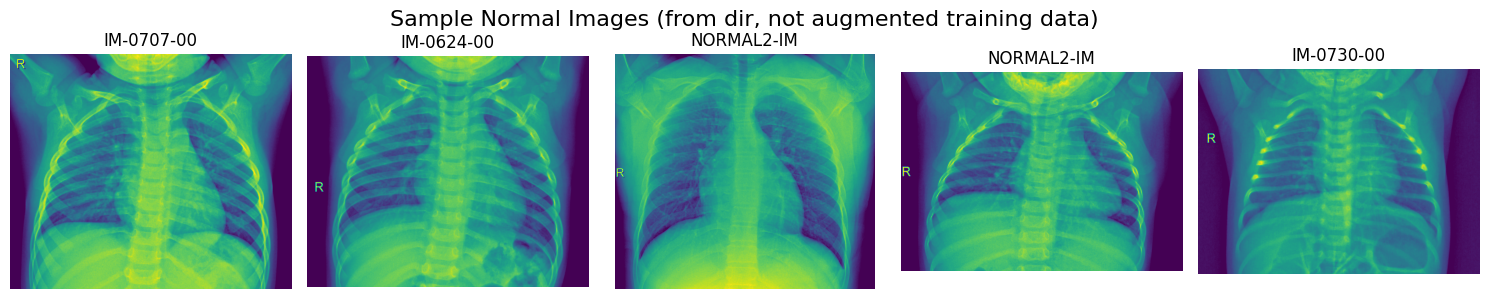

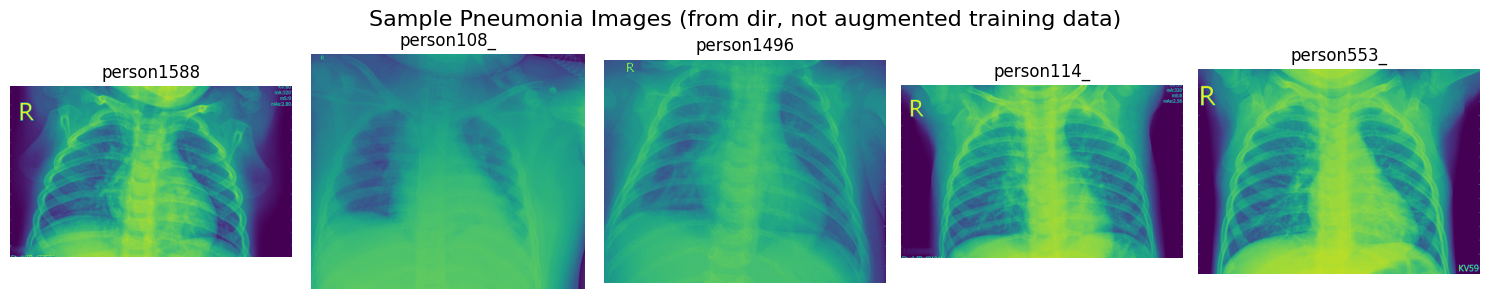

In [ ]:
# Visualize images from a given directory
def visualize_sample_images(data_dir, title, num_images=5):
    image_paths = os.listdir(data_dir)[:num_images]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')
    for i, img_file in enumerate(image_paths):
        img = plt.imread(os.path.join(data_dir, img_file))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(img_file[:10])  # Show partial filename
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_sample_images(os.path.join(train_dir, "NORMAL"), "Sample Normal Images (from dir, not augmented training data)")
visualize_sample_images(os.path.join(train_dir, "PNEUMONIA"), "Sample Pneumonia Images (from dir, not augmented training data)")


In [ ]:
# Plot training accuracy and loss
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), facecolor='white')

    # Accuracy plot
    axs[0].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    axs[0].set_title('Accuracy over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Loss plot
    axs[1].plot(history.history['loss'], label='Train Loss', color='blue')
    axs[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
    axs[1].set_title('Loss over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


## ResNet50 Model

In [ ]:
# # Unfreeze the last few layers of ResNet50
# def fine_tune_resnet50_model(model, num_layers_to_unfreeze):
#     base_model = model.layers[0]  # Extract the pre-trained ResNet50 base model
#     for layer in base_model.layers[-num_layers_to_unfreeze:]:
#         layer.trainable = True  # Unfreeze these layers

#     # Compile the model again with a lower learning rate
#     model.compile(optimizer=Adam(learning_rate=0.0001),  # Fine-tuning requires a smaller learning rate
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

#     return model



In [ ]:

# def build_model(input_shape):
#     base_model = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")

#     base_model.trainable = False  # Unfreeze the base model (deeper layers to adapt these specific features to the pneumonia dataset)

#     model = Sequential([
#         base_model,
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dense(1, activation='sigmoid')  # Binary classification
#     ])
#     model.compile(optimizer=Adam(learning_rate=0.001),
#                   loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# model = build_model((*IMAGE_SIZE, 3))

# # Early stopping callback
# early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# # Train model
# history = model.fit(
#     train_generator, validation_data=val_generator, epochs=10, callbacks=[early_stopping]
# )
# model.summary()
# plot_training_history(history)

In [ ]:
# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f"Test Accuracy: {test_accuracy:.2f}")

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# # Generate predictions
# y_pred = model.predict(test_generator)
# y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary classes
# y_true = test_generator.classes  # True labels from the generator

# # Create confusion matrix
# cm = confusion_matrix(y_true, y_pred_classes, labels=[0, 1])

# # Display confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
# disp.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
# plt.show()

In [ ]:

#Finetuned model

# model = fine_tune_resnet50_model(model, num_layers_to_unfreeze=10)

# # Early stopping callback
# early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# # Train model
# history = model.fit(
#     train_generator, validation_data=val_generator, epochs=10, callbacks=[early_stopping]
# )
# model.summary()
# plot_training_history(history)


In [ ]:
# test_loss, test_accuracy = model.evaluate(test_generator)
# print(f"Test Accuracy: {test_accuracy:.2f}")


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# # Generate predictions
# y_pred = model.predict(test_generator)
# y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary classes
# y_true = test_generator.classes  # True labels from the generator

# # Create confusion matrix
# cm = confusion_matrix(y_true, y_pred_classes, labels=[0, 1])

# # Display confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
# disp.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
# plt.show()

# Custom CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_custom_cnn(input_shape):
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))  # Extract features with 32 filters
    model.add(BatchNormalization())  # Normalize activations for faster convergence
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Downsample spatial dimensions
    model.add(Dropout(0.25))  # Mitigate overfitting

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu'))  # Extract deeper features with 64 filters
    model.add(BatchNormalization())  # Normalize activations for stability
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduce spatial dimensions
    model.add(Dropout(0.25))  # Prevent overfitting

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu'))  # Extract higher-level features with 128 filters
    model.add(BatchNormalization())  # Normalize activations
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Further reduce spatial dimensions
    model.add(Dropout(0.25))  # Mitigate overfitting

    # Fully Connected Layers
    model.add(Flatten())  # Flatten feature maps for dense layers
    model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
    model.add(Dropout(0.5))  # Reduce overfitting
    model.add(Dense(1, activation='sigmoid'))  # Activation function for binary classification

    # Compile the model
    model.compile(
        optimizer='adam',  # Adaptive learning rate optimization
        loss='binary_crossentropy',  # Loss for binary classification
        metrics=['accuracy']  # Track accuracy during training
    )
    return model

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 135s 830ms/step - accuracy: 0.7809 - loss: 6.0492 - val_accuracy: 0.7428 - val_loss: 43.6332
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 124s 802ms/step - accuracy: 0.8340 - loss: 0.3745 - val_accuracy: 0.7428 - val_loss: 42.2702
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 122s 785ms/step - accuracy: 0.8706 - loss: 0.3232 - val_accuracy: 0.7428 - val_loss: 6.2862
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 121s 782ms/step - accuracy: 0.8850 - loss: 0.2602 - val_accuracy: 0.7428 - val_loss: 8.5177
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 122s 787ms/step - accuracy: 0.8745 - loss: 0.2992 - val_accuracy: 0.5125 - val_loss: 1.0327
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 140s 786ms/step - accuracy: 0.8910 - loss: 0.2601 - val_accuracy: 0.7428 - val_loss: 28.3038
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 122s 789ms/step - accuracy: 0.8925 - loss: 0.2473 - val_accuracy: 0.6219 - val_loss: 1.7711
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 122s 794ms/step - accuracy: 0.905

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,519,109 (169.83 MB)

 Trainable params: 14,839,553 (56.61 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 29,679,108 (113.22 MB)

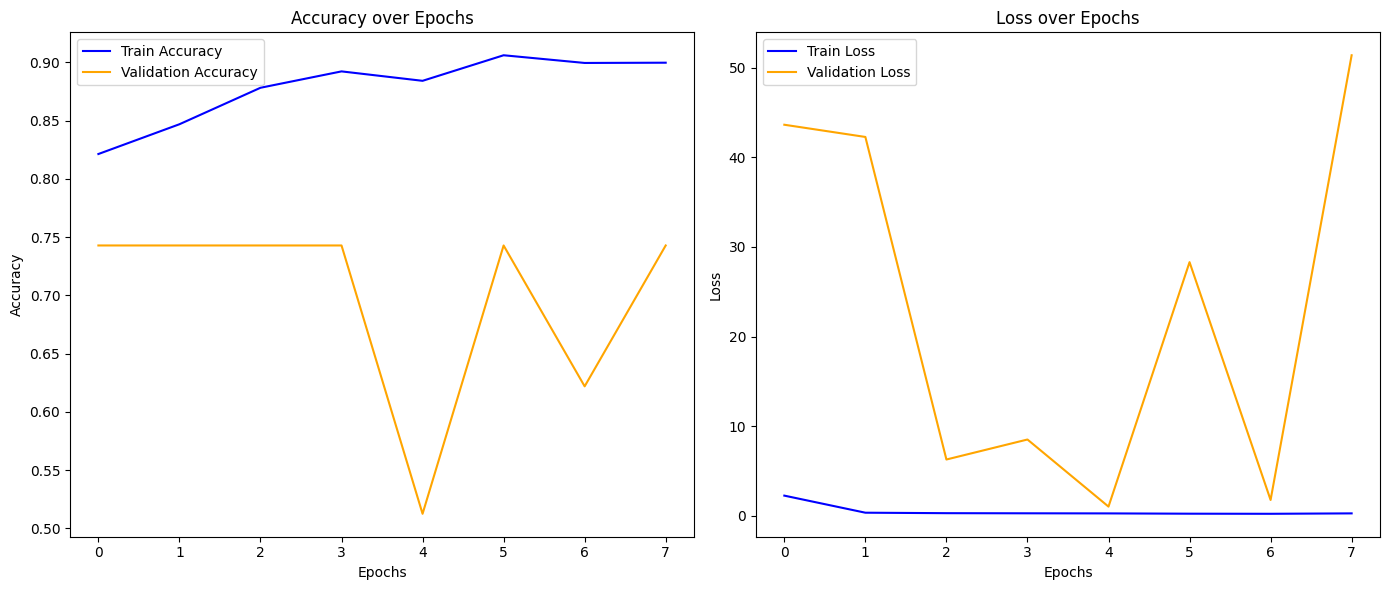

In [ ]:
# Define the input shape (e.g., (256, 256, 3) for RGB images of size 256x256)
input_shape = (*IMAGE_SIZE, 3)

# Build the model
custom_cnn_model = build_custom_cnn(input_shape)
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
# Train the model
history = custom_cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]
)
custom_cnn_model.summary()
plot_training_history(history)

In [ ]:
test_loss, test_accuracy = custom_cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - accuracy: 0.8202 - loss: 0.3724
Test Accuracy: 0.61


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step


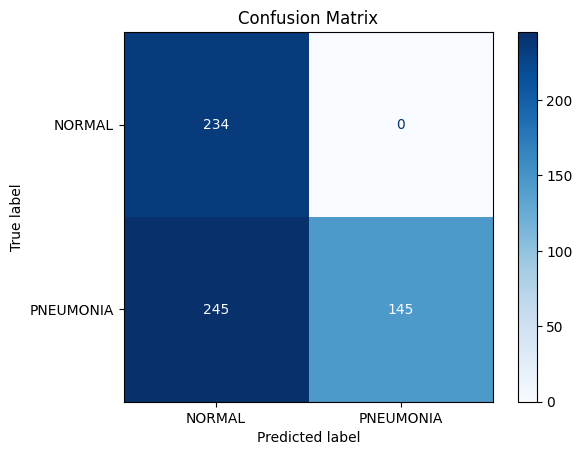

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions
y_pred = custom_cnn_model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary classes
y_true = test_generator.classes  # True labels from the generator

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=[0, 1])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:\n")
print(class_report)


Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.49      1.00      0.66       234
   PNEUMONIA       1.00      0.37      0.54       390

    accuracy                           0.61       624
   macro avg       0.74      0.69      0.60       624
weighted avg       0.81      0.61      0.58       624



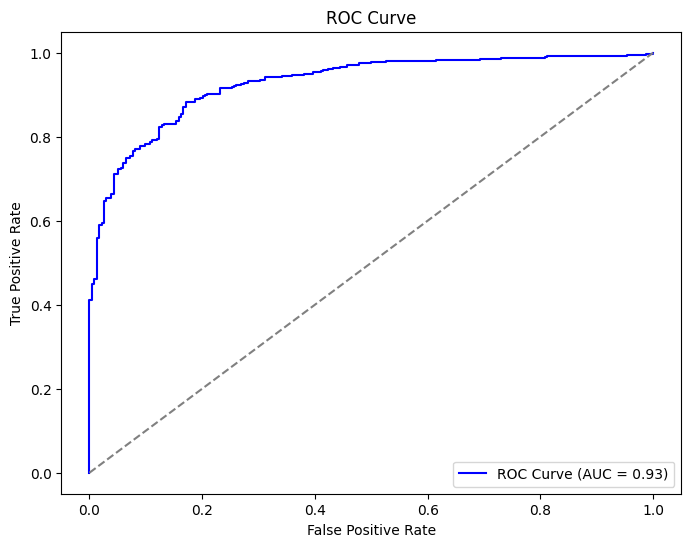

In [ ]:
from sklearn.metrics import roc_curve, auc

# Generate probabilities
y_pred_proba = y_pred.flatten()  # Probabilities from the model

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

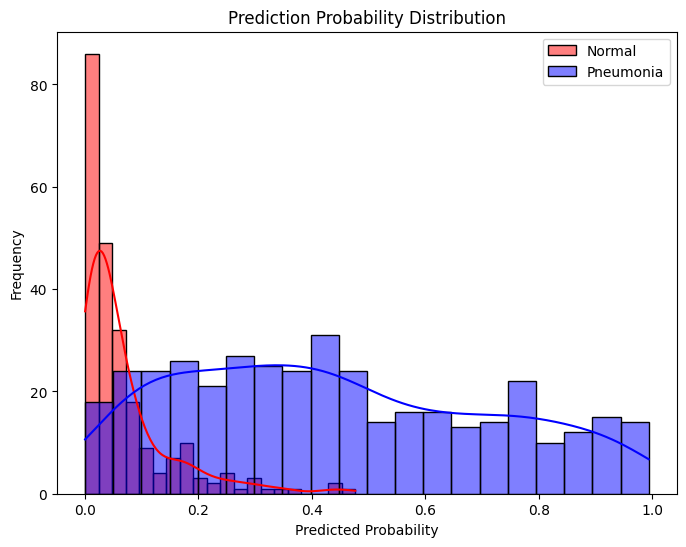

In [ ]:
# creating histogram
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba[y_true == 0], bins=20, color='red', label='Normal', kde=True)
sns.histplot(y_pred_proba[y_true == 1], bins=20, color='blue', label='Pneumonia', kde=True)
plt.title('Prediction Probability Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()